In [1]:
# PACKAGES
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd

import scipy.signal as signal
from scipy.io import wavfile
from tqdm import tqdm
from scipy import stats
from scipy.signal import get_window, hilbert
from scipy.fft import fft

from enfify.enf_estimation import (segmented_phase_estimation_hilbert, phase_estimation_DFT1, STFT)
from enfify.preprocessing import (bandpass_filter, downsample_ffmpeg,  cut_signal)
from tqdm import tqdm

from enfify.enf_enhancement import RFA_STFT, RFA_DFT1, RFA, VMD

In [2]:
def freq_estimation_DFT1(s_tone, Fs, N_DFT):
    """_summary_

    Args:
        s_tone (_type_): _description_
        Fs (_type_): _description_
        N_DFT (_type_): _description_

    Returns:
        _type_: _description_
    """

    # ......Estimate the frequency......#
    window_type = "hann"
    M = len(s_tone)

    # Get the window type
    window = get_window(window_type, M - 1)

    # Calculate the approx. first derivative of single tone
    s_tone_diff = Fs * np.diff(s_tone)
    s_tone = s_tone[1:]

    # Windowing
    s_tone_windowed = s_tone * window
    s_tone_diff_windowed = s_tone_diff * window

    # Zero-Padding of the signal
    s_tone_padded = np.pad(s_tone_windowed, (0, N_DFT - M), "constant")
    s_tone_padded_diff = np.pad(s_tone_diff_windowed, (0, N_DFT - M), "constant")

    # Calculate the DFT
    X = fft(s_tone_padded, n=N_DFT)
    X_diff = fft(s_tone_padded_diff, n=N_DFT)

    # Compute the amplitude spectrum and max. amplitude
    abs_X = np.abs(X)
    k_max = np.argmax(abs_X)
    abs_X_diff = np.abs(X_diff)

    # Estimated frequency of the single tone
    F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max / N_DFT))
    f0_estimated = (F_kmax * abs_X_diff[k_max]) / (2 * np.pi * abs_X[k_max])

    # Validate the frequency result
    k_DFT = (N_DFT * f0_estimated) / Fs
    try:
        k_DFT >= (k_max - 0.5) and k_DFT < (k_max + 0.5)
    except ValueError:
        print("estimated frequency is not valid")

    return f0_estimated


def segmented_freq_estimation_DFT1(s_in, f_s, N_DFT, step_size, window_len):
    """_summary_

    Args:
        s_in (_type_): _description_
        f_s (_type_): _description_
        num_cycles (_type_): _description_
        N_DFT (_type_): _description_
        nominal_enf (_type_): _description_

    Returns:
        _type_: _description_
    """

    segments = []

    for i in range(0, len(s_in), step_size):
        segments.append(s_in[i : i + window_len])

    freqs = []
    for i in range(len(segments)):
        freq = freq_estimation_DFT1(segments[i], f_s, N_DFT)
        freqs.append(freq)

    return np.array(freqs)

In [3]:
# Data Paths

# Wuhan
WUHAN_H1_PTH = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/external/ENF-WHU-Dataset/H1"
WUHAN_H1REF_PTH = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/external/ENF-WHU-Dataset/H1_ref"

# Carioca
CARIOCA1_MAN = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/external/Carioca/BASE CARIOCA 1/Homens"
CARIOCA2_MAN = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/external/Carioca/BASE CARIOCA 2/Fixo/Homens"

wuhan_h1_files = sorted(os.listdir(WUHAN_H1_PTH))
print(wuhan_h1_files)

wuhan_h1ref_files = sorted(os.listdir(WUHAN_H1REF_PTH))
print(wuhan_h1ref_files)

carioca1_cut = [f"HC{i}e.wav" for i in range(1,26)]
print(carioca1_cut)

carioca1_uncut = [f"HC{i}.wav" for i in range(1,26)]
print(carioca1_uncut)

['001.wav', '002.wav', '003.wav', '004.wav', '005.wav', '006.wav', '007.wav', '008.wav', '009.wav', '010.wav', '011.wav', '012.wav', '013.wav', '014.wav', '015.wav', '016.wav', '017.wav', '018.wav', '019.wav', '020.wav', '021.wav', '022.wav', '023.wav', '024.wav', '025.wav', '026.wav', '027.wav', '028.wav', '029.wav', '030.wav', '031.wav', '032.wav', '033.wav', '034.wav', '035.wav', '036.wav', '037.wav', '038.wav', '039.wav', '040.wav', '041.wav', '042.wav', '043.wav', '044.wav', '045.wav', '046.wav', '047.wav', '048.wav', '049.wav', '050.wav', '051.wav', '052.wav', '053.wav', '054.wav', '055.wav', '056.wav', '057.wav', '058.wav', '059.wav', '060.wav', '061.wav', '062.wav', '063.wav', '064.wav', '065.wav', '066.wav', '067.wav', '068.wav', '069.wav', '070.wav', '071.wav', '072.wav', '073.wav', '074.wav', '075.wav', '076.wav', '077.wav', '078.wav', '079.wav', '080.wav', '081.wav', '082.wav', '083.wav', '084.wav', '085.wav', '086.wav', '087.wav', '088.wav', '089.wav', '090.wav', '091.wav'

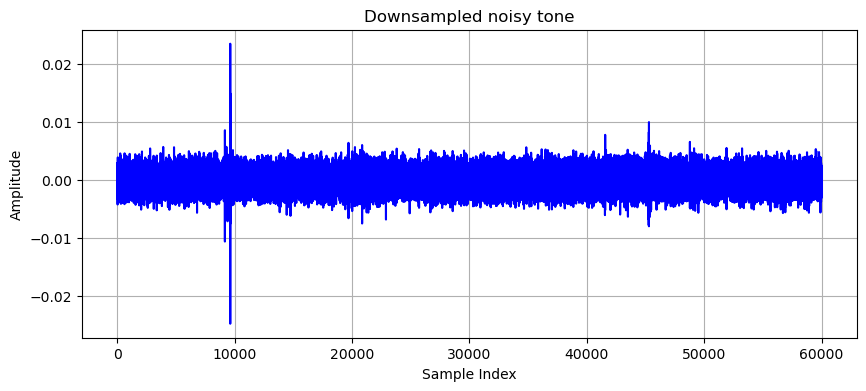

/tmp/ipykernel_6989/2980598283.py:42: RuntimeWarning: invalid value encountered in scalar divide
  F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max / N_DFT))


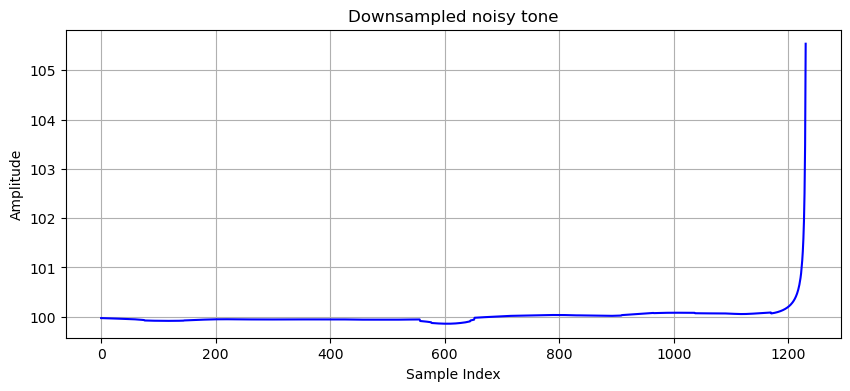

Segment start index: 2858
Segment end index: 3934


In [6]:
from scipy.io import wavfile

# Window Size comparision
#RFA
tau = int(2500)
I = 5
epsilon = 1e-20

#Bandpass Filter
lowcut = 99.5
highcut = 100.5
order = 5
down_sample_rate = 1000
nominal_enf = 100
k = 2
N_DFT = 20_000

#Cut
cut_start = 28_584
cut_len = 10_756

step_size = 40
window_len = 8001

cut_pth = os.path.join(WUHAN_H1_PTH, wuhan_h1_files[k])
cut_sample_rate, cut_data = wavfile.read(cut_pth)
cut_down_sig_ffmpeg, down_sample_rate = downsample_ffmpeg(cut_data, cut_sample_rate, down_sample_rate)
cut_down_sig_ffmpeg = cut_down_sig_ffmpeg[20_000:80_001]
cut_down_sig_ffmpeg = cut_signal(cut_down_sig_ffmpeg, cut_start, cut_len)
cut_band_sig_ffmpeg = bandpass_filter(cut_down_sig_ffmpeg, lowcut, highcut, down_sample_rate, order)

uncut_pth = os.path.join(WUHAN_H1_PTH, wuhan_h1_files[k])
uncut_data, uncut_sample_rate = librosa.load(uncut_pth, sr=None)
uncut_down_sig_ffmpeg = librosa.resample(uncut_data, orig_sr = uncut_sample_rate, target_sr = down_sample_rate)
uncut_down_sig_ffmpeg = uncut_down_sig_ffmpeg[20_000:80_001]
uncut_band_sig_ffmpeg = bandpass_filter(uncut_down_sig_ffmpeg, lowcut, highcut, down_sample_rate, order)

ref_pth = os.path.join(WUHAN_H1REF_PTH, wuhan_h1ref_files[k])
ref_data, ref_sample_rate = librosa.load(ref_pth, sr=None)
ref_down_sig_ffmpeg = librosa.resample(ref_data, orig_sr=ref_sample_rate, target_sr=down_sample_rate)
ref_down_sig_ffmpeg = ref_down_sig_ffmpeg[20_000:80_001]
ref_band_sig_ffmpeg = bandpass_filter(ref_data, lowcut, highcut, down_sample_rate, order)

plt.figure(figsize=(10, 4))
plt.plot(uncut_down_sig_ffmpeg, color="blue")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

freqs_DFT1_cut = segmented_freq_estimation_DFT1(cut_band_sig_ffmpeg, down_sample_rate, N_DFT, step_size, window_len)
plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="blue")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Segment indices
segment_start = cut_start // 10  # Find the segment index corresponding to cut_start
segment_end = (cut_start + cut_len) // 10  # Find the segment index for the end of the cut

print(f"Segment start index: {segment_start}")
print(f"Segment end index: {segment_end}")

In [49]:
for i in tqdm(range(1)):    
    alpha =  2_000            # Balancing parameter of the data-fidelity constraint
    tau = 0                 # Noise-tolerance (no strict fidelity enforcement)
    n_mode = 2              # Number of modes to be recovered
    DC = 0
    tol =1e-7    # Tolerance of convergence criterion

    u_clean_cut, _, _ = VMD(cut_band_sig_ffmpeg[:-1], alpha, tau, n_mode, DC, tol)
    bandpass_sig_cut = u_clean_cut[0]

100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


In [ ]:
freqs_DFT1_cut = segmented_freq_estimation_DFT1(cut_band_sig_ffmpeg, 1000, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="blue")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

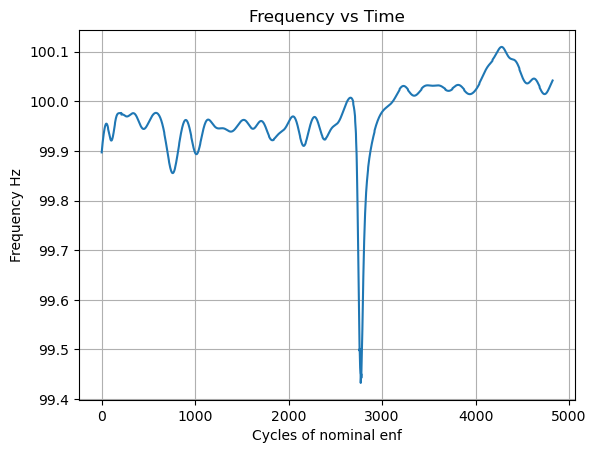

 20%|██        | 1/5 [00:40<02:42, 40.58s/it]

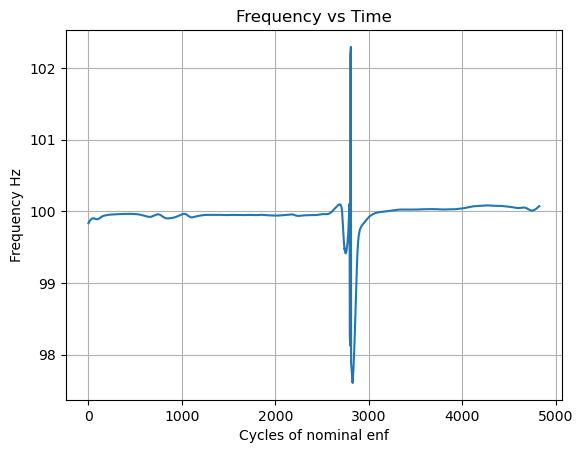

 40%|████      | 2/5 [00:50<01:08, 22.79s/it]

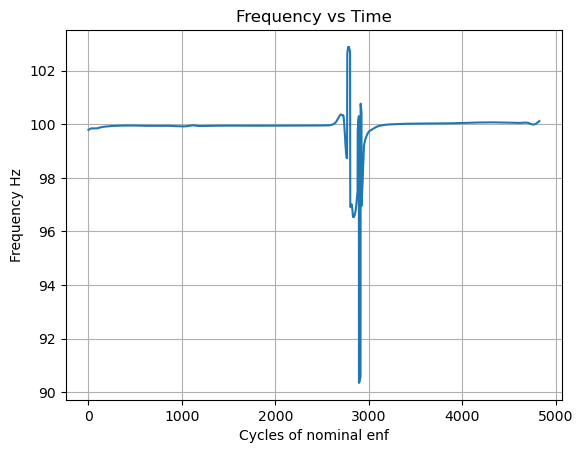

 60%|██████    | 3/5 [01:00<00:33, 16.73s/it]

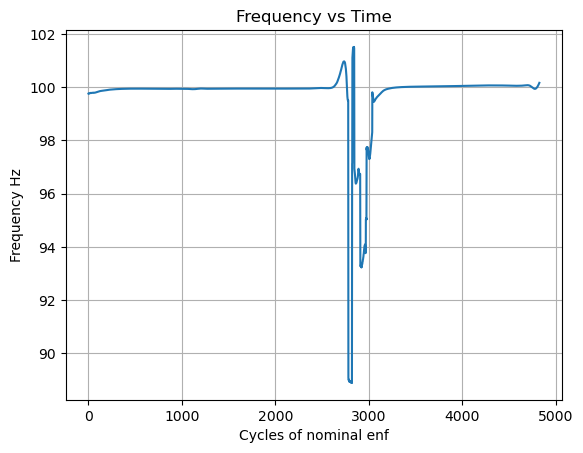

 80%|████████  | 4/5 [01:10<00:13, 13.94s/it]

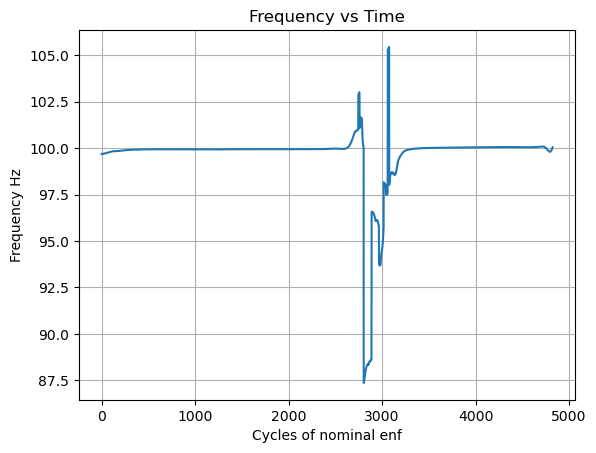

100%|██████████| 5/5 [01:19<00:00, 15.95s/it]


In [5]:
epsilon = 1e-20
#uncut_stft = RFA(bandpass_sig, down_sample_rate, tau, epsilon, I, nominal_enf)

cut_DFT1 = RFA(cut_band_sig_ffmpeg, down_sample_rate, tau, epsilon, I, nominal_enf)

#uncut_DFT1 = RFA(bandpass_sig, down_sample_rate, tau, I, nominal_enf, window_len, step_size)

#cut_STFT = RFA_STFT(cut_band_sig_ffmpeg, down_sample_rate, tau, I, nominal_enf, window_len, step_size)

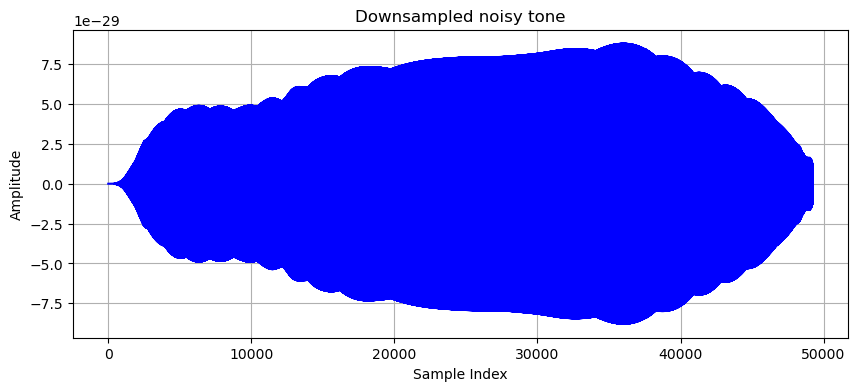

In [90]:
plt.figure(figsize=(10, 4))
plt.plot(cut_DFT1, color="blue")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()